# Fire Patch Preview

Visualize random fire candidates from Sentinel-2


In [18]:
import os
import math
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

from sentinelhub import (
    SHConfig, SentinelHubRequest, DataCollection,
    MimeType, CRS, BBox
)

load_dotenv()

# Config
config = SHConfig(use_defaults=True)
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")

print("✓ Credentials loaded" if config.sh_client_id else "✗ Missing credentials")


✓ Credentials loaded


In [ ]:
# Load fire download points
DATA = Path("..") / "data" / "processed"
FIGURES = Path("..") / "data" / "figures"
FIGURES.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA / "fire_download.csv")

print(f"Total fire points: {len(df)}")
df.head(3)


Total fire points: 986


event_id  latitude  longitude                   firms_dt   frp  \
0  2023-07-15_12  43.17289   46.85097  2023-07-15 09:29:00+00:00  5.41   
1  2023-07-15_14  44.53379   46.75423  2023-07-15 09:30:00+00:00  9.37   
2  2023-07-15_17  46.94200   33.71293  2023-07-15 09:31:00+00:00  5.52   

  confidence  type  event_n                      s2_dt  cloud  \
0          n     0        2  2023-07-15 07:58:01+00:00   2.56   
1          n     0        2  2023-07-15 07:57:32+00:00  12.05   
2          n     0        2  2023-07-15 08:47:26+00:00   8.10   

                                             item_id  tile  delta_signed  \
0  S2B_MSIL2A_20230715T074619_N0509_R135_T38TPN_2...   NaN     -1.516389   
1  S2B_MSIL2A_20230715T074619_N0509_R135_T38TPQ_2...   NaN     -1.541111   
2  S2A_MSIL2A_20230715T083601_N0509_R064_T36TWS_2...   NaN     -0.726111   

      delta    ok  
0  1.516389  True  
1  1.541111  True  
2  0.726111  True

In [20]:
# Settings
N_TARGET = 10         # How many valid images to find
SWIR_THRESHOLD = 0.6  # B12 must be above this to count as "visible fire"
MAX_ATTEMPTS = 50     # Stop after this many attempts

print(f"Finding {N_TARGET} images with SWIR max > {SWIR_THRESHOLD}...")
print(f"Pool size: {len(df)} fire candidates")


Finding 10 images with SWIR max > 0.6...
Pool size: 986 fire candidates


In [21]:
PATCH_SIZE = 224
RESOLUTION = 10

def make_bbox(lat, lon, size_m):
    half = size_m / 2
    dlat = half / 111320
    dlon = half / (111320 * math.cos(math.radians(lat)))
    return BBox([lon - dlon, lat - dlat, lon + dlon, lat + dlat], crs=CRS.WGS84)

# RGB + SWIR2 + False Color
EVALSCRIPT = """
//VERSION=3
function setup() {
    return {
        input: ["B02", "B03", "B04", "B08", "B12", "dataMask"],
        output: [
            { id: "rgb", bands: 3, sampleType: "FLOAT32" },
            { id: "swir", bands: 1, sampleType: "FLOAT32" },
            { id: "falsecolor", bands: 3, sampleType: "FLOAT32" },
            { id: "mask", bands: 1, sampleType: "UINT8" }
        ]
    };
}

function evaluatePixel(s) {
    return {
        rgb: [s.B04 * 3.5, s.B03 * 3.5, s.B02 * 3.5],
        swir: [s.B12],
        falsecolor: [s.B12 * 2.5, s.B08 * 2, s.B04 * 2],
        mask: [s.dataMask]
    };
}
"""

def is_too_cloudy(rgb_image, threshold=0.95, max_cloud_percent=0.4):
    """
    Check if image has too many clouds.
    RGB values are 0-1, so we check if pixels are very bright (white).
    """
    # Count pixels that are bright in all channels (likely clouds)
    white_pixels = np.all(rgb_image > threshold, axis=-1)
    cloud_percent = np.sum(white_pixels) / white_pixels.size
    return cloud_percent > max_cloud_percent

def fetch_patch(lat, lon, s2_dt):
    bbox = make_bbox(lat, lon, PATCH_SIZE * RESOLUTION)
    date = pd.to_datetime(s2_dt).date() if isinstance(s2_dt, str) else s2_dt.date()
    
    request = SentinelHubRequest(
        evalscript=EVALSCRIPT,
        input_data=[SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=(str(date), str(date + dt.timedelta(days=1))),
        )],
        responses=[
            SentinelHubRequest.output_response("rgb", MimeType.TIFF),
            SentinelHubRequest.output_response("swir", MimeType.TIFF),
            SentinelHubRequest.output_response("falsecolor", MimeType.TIFF),
            SentinelHubRequest.output_response("mask", MimeType.TIFF),
        ],
        bbox=bbox,
        size=(PATCH_SIZE, PATCH_SIZE),
        config=config,
    )
    return request.get_data()[0]

print("✓ Functions ready")


✓ Functions ready


In [22]:
# Keep sampling until we have N_TARGET images with SWIR > threshold and low cloud
patches = []
used_ids = set()
attempts = 0
skip_reasons = {"swir_low": 0, "too_cloudy": 0, "error": 0}

while len(patches) < N_TARGET and attempts < MAX_ATTEMPTS:
    # Pick a random candidate we haven't tried
    remaining = df[~df["event_id"].isin(used_ids)]
    if len(remaining) == 0:
        print("No more candidates!")
        break
    
    row = remaining.sample(1).iloc[0]
    used_ids.add(row["event_id"])
    attempts += 1
    
    print(f"[{attempts}] {row['event_id'][:20]}...", end=" ")
    
    try:
        data = fetch_patch(row["latitude"], row["longitude"], row["s2_dt"])
        rgb = np.clip(data["rgb.tif"], 0, 1)
        swir = data["swir.tif"] if data["swir.tif"].ndim == 2 else data["swir.tif"][:, :, 0]
        swir_max = swir.max()
        
        # Check cloud cover
        if is_too_cloudy(rgb):
            print(f"✗ Too cloudy")
            skip_reasons["too_cloudy"] += 1
            continue
        
        # Check SWIR threshold
        if swir_max > SWIR_THRESHOLD:
            patches.append({"row": row, **data})
            print(f"✓ SWIR={swir_max:.2f} [{len(patches)}/{N_TARGET}]")
        else:
            print(f"✗ SWIR={swir_max:.2f} (too low)")
            skip_reasons["swir_low"] += 1
    except Exception as e:
        print(f"✗ Error: {e}")
        skip_reasons["error"] += 1

print(f"\nFound {len(patches)}/{N_TARGET} images with visible fire (tried {attempts})")
print(f"Skipped: {skip_reasons['swir_low']} low SWIR, {skip_reasons['too_cloudy']} cloudy, {skip_reasons['error']} errors")


[1] 2023-08-11_62... ✓ SWIR=1.51 [1/10]
[2] 2023-08-06_87... ✗ SWIR=0.33 (too low)
[3] 2023-07-31_85... ✓ SWIR=1.41 [2/10]
[4] 2023-07-24_91... ✗ SWIR=0.37 (too low)
[5] 2023-08-07_105... ✓ SWIR=1.39 [3/10]
[6] 2023-08-13_121... ✓ SWIR=1.51 [4/10]
[7] 2023-08-06_249... ✗ SWIR=0.40 (too low)
[8] 2023-08-08_8... ✓ SWIR=1.53 [5/10]
[9] 2023-08-08_54... ✗ SWIR=0.43 (too low)
[10] 2023-07-27_16... ✓ SWIR=0.77 [6/10]
[11] 2023-08-09_26... ✓ SWIR=1.51 [7/10]
[12] 2023-08-01_28... ✗ SWIR=0.54 (too low)
[13] 2023-07-18_84... ✓ SWIR=1.51 [8/10]
[14] 2023-07-19_38... ✗ SWIR=0.41 (too low)
[15] 2023-08-14_132... ✗ SWIR=0.48 (too low)
[16] 2023-08-02_99... ✗ SWIR=0.47 (too low)
[17] 2023-08-13_35... ✗ Too cloudy
[18] 2023-07-24_46... ✓ SWIR=0.68 [9/10]
[19] 2023-07-28_54... ✗ SWIR=0.49 (too low)
[20] 2023-07-23_78... ✓ SWIR=1.53 [10/10]

Found 10/10 images with visible fire (tried 20)
Skipped: 9 low SWIR, 1 cloudy, 0 errors


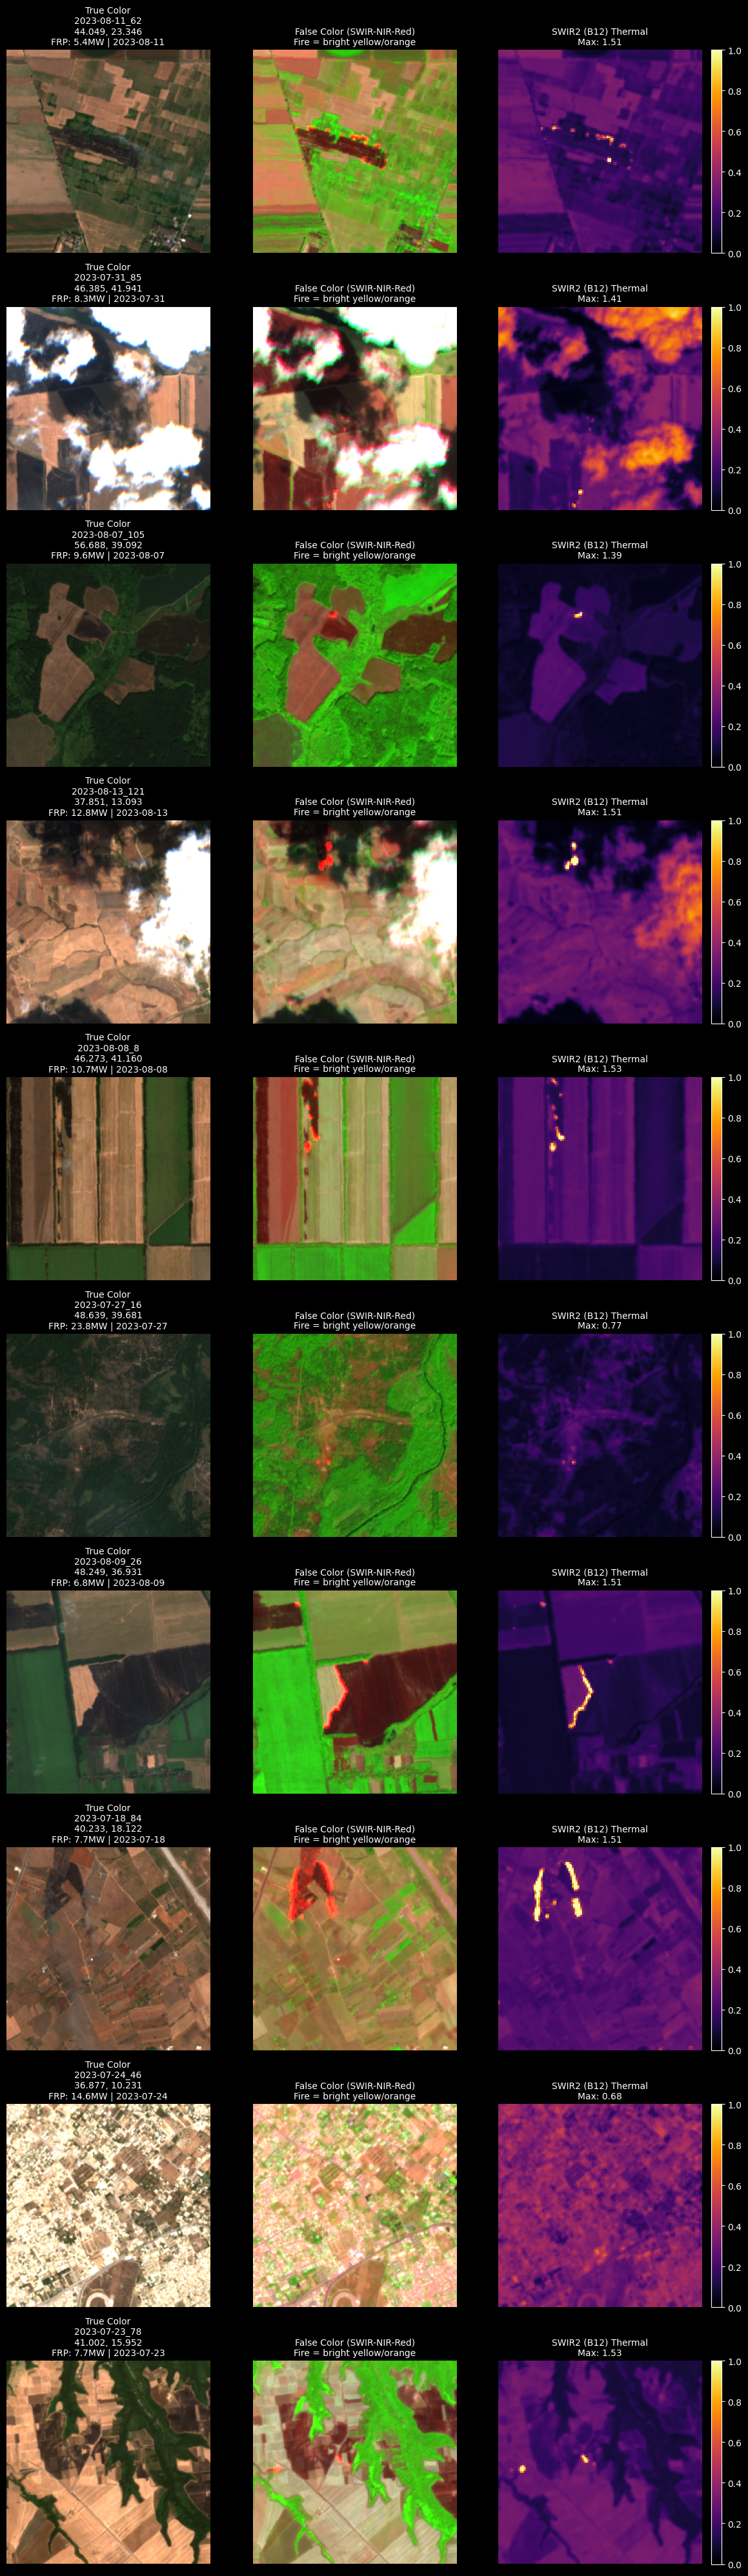

Saved: data/fire_preview.png


In [ ]:
# Plot all found patches
n_patches = len(patches)
if n_patches == 0:
    print("No patches to display!")
else:
    plt.style.use('dark_background')
    fig, axes = plt.subplots(n_patches, 3, figsize=(12, 4 * n_patches))
    if n_patches == 1:
        axes = axes.reshape(1, -1)  # Make 2D for consistency
    
    for i, p in enumerate(patches):
        row = p["row"]
        rgb = np.clip(p["rgb.tif"], 0, 1)
        swir = p["swir.tif"] if p["swir.tif"].ndim == 2 else p["swir.tif"][:, :, 0]
        fc = np.clip(p["falsecolor.tif"], 0, 1)
        
        # Info
        date = row["s2_dt"][:10] if isinstance(row["s2_dt"], str) else str(row["s2_dt"])[:10]
        title = f"{row['event_id']}\n{row['latitude']:.3f}, {row['longitude']:.3f}\nFRP: {row['frp']:.1f}MW | {date}"
        
        # RGB
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title(f"True Color\n{title}", fontsize=10, color="white")
        axes[i, 0].axis("off")
        
        # False color
        axes[i, 1].imshow(fc)
        axes[i, 1].set_title("False Color (SWIR-NIR-Red)\nFire = bright yellow/orange", fontsize=10, color="white")
        axes[i, 1].axis("off")
        
        # SWIR2 thermal
        im = axes[i, 2].imshow(swir, cmap="inferno", vmin=0, vmax=1.0)
        axes[i, 2].set_title(f"SWIR2 (B12) Thermal\nMax: {swir.max():.2f}", fontsize=10, color="white")
        axes[i, 2].axis("off")
        plt.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig(FIGURES / "fire_preview.png", dpi=150, facecolor='#1a1a1a')
    plt.show()
    print(f"Saved: {FIGURES / 'fire_preview.png'}")


In [24]:
# Summary
print("=" * 50)
print("🔥 FIRE DETECTION SUMMARY")
print("=" * 50)

for i, p in enumerate(patches):
    if p is None:
        continue
    row = p["row"]
    swir = p["swir.tif"] if p["swir.tif"].ndim == 2 else p["swir.tif"][:, :, 0]
    mask = p["mask.tif"] if p["mask.tif"].ndim == 2 else p["mask.tif"][:, :, 0]
    
    # Simple hotspot detection
    hotspots = (swir > 0.25) & (mask > 0)
    pct = hotspots.sum() / mask.sum() * 100 if mask.sum() > 0 else 0
    
    print(f"\n{i+1}. {row['event_id']}")
    print(f"   📍 {row['latitude']:.4f}°N, {row['longitude']:.4f}°E")
    print(f"   📅 {row['s2_dt'][:10]}")
    print(f"   🔥 FRP: {row['frp']:.1f} MW")
    print(f"   ☁️  Cloud: {row['cloud']:.1f}%")
    print(f"   🌡️  SWIR max: {swir.max():.3f}")
    print(f"   🎯 Hotspot pixels: {hotspots.sum()} ({pct:.1f}%)")


🔥 FIRE DETECTION SUMMARY

1. 2023-08-11_62
   📍 44.0491°N, 23.3460°E
   📅 2023-08-11
   🔥 FRP: 5.4 MW
   ☁️  Cloud: 6.8%
   🌡️  SWIR max: 1.509
   🎯 Hotspot pixels: 16189 (32.3%)

2. 2023-07-31_85
   📍 46.3852°N, 41.9411°E
   📅 2023-07-31
   🔥 FRP: 8.3 MW
   ☁️  Cloud: 29.0%
   🌡️  SWIR max: 1.408
   🎯 Hotspot pixels: 28021 (55.8%)

3. 2023-08-07_105
   📍 56.6878°N, 39.0921°E
   📅 2023-08-07
   🔥 FRP: 9.6 MW
   ☁️  Cloud: 0.0%
   🌡️  SWIR max: 1.393
   🎯 Hotspot pixels: 380 (0.8%)

4. 2023-08-13_121
   📍 37.8506°N, 13.0933°E
   📅 2023-08-13
   🔥 FRP: 12.8 MW
   ☁️  Cloud: 3.6%
   🌡️  SWIR max: 1.507
   🎯 Hotspot pixels: 31619 (63.0%)

5. 2023-08-08_8
   📍 46.2735°N, 41.1604°E
   📅 2023-08-08
   🔥 FRP: 10.7 MW
   ☁️  Cloud: 0.0%
   🌡️  SWIR max: 1.526
   🎯 Hotspot pixels: 16805 (33.5%)

6. 2023-07-27_16
   📍 48.6394°N, 39.6810°E
   📅 2023-07-27
   🔥 FRP: 23.8 MW
   ☁️  Cloud: 0.0%
   🌡️  SWIR max: 0.769
   🎯 Hotspot pixels: 448 (0.9%)

7. 2023-08-09_26
   📍 48.2495°N, 36.9310°E
   📅 202

Testing random sample of 100 fire images...
[100/100] Fetching...

QUALITY TEST RESULTS
Total tested:      100
Clear images:      98 (98%)
Too cloudy:        2 (2%)
Errors:            0

SWIR analysis (clear images only):
SWIR max > 0.6:    58 (59.2%)
SWIR max ≤ 0.6:    40 (40.8%)

SWIR max stats:
  Min:    0.176
  Max:    1.542
  Mean:   0.981
  Median: 1.226

✅ Good quality images (clear + SWIR>0.6): 58/100 (58%)


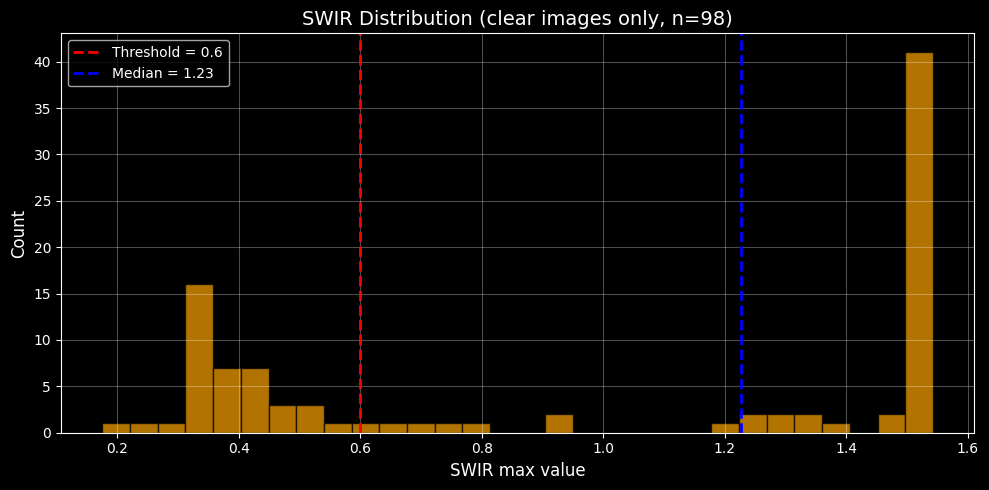


Saved: data/swir_distribution.png


In [ ]:
# Test on random sample: How many have SWIR > 0.5 and low cloud?
N_TEST = 100
print(f"Testing random sample of {N_TEST} fire images...")
print("=" * 50)

test_samples = df.sample(min(N_TEST, len(df)))
swir_values = []
test_stats = {"cloudy": 0, "clear": 0, "error": 0}

for i, row in test_samples.iterrows():
    print(f"\r[{test_stats['clear']+test_stats['cloudy']+test_stats['error']+1}/{len(test_samples)}] Fetching...", end="")
    try:
        data = fetch_patch(row["latitude"], row["longitude"], row["s2_dt"])
        rgb = np.clip(data["rgb.tif"], 0, 1)
        swir = data["swir.tif"] if data["swir.tif"].ndim == 2 else data["swir.tif"][:, :, 0]
        
        if is_too_cloudy(rgb):
            test_stats["cloudy"] += 1
        else:
            swir_values.append(swir.max())
            test_stats["clear"] += 1
    except:
        test_stats["error"] += 1

print(f"\n\n{'='*50}")
print("QUALITY TEST RESULTS")
print("=" * 50)
print(f"Total tested:      {len(test_samples)}")
print(f"Clear images:      {test_stats['clear']} ({test_stats['clear']/len(test_samples)*100:.0f}%)")
print(f"Too cloudy:        {test_stats['cloudy']} ({test_stats['cloudy']/len(test_samples)*100:.0f}%)")
print(f"Errors:            {test_stats['error']}")

if swir_values:
    above = sum(1 for v in swir_values if v > SWIR_THRESHOLD)
    below = len(swir_values) - above
    
    print(f"\nSWIR analysis (clear images only):")
    print(f"SWIR max > {SWIR_THRESHOLD}:    {above} ({above/len(swir_values)*100:.1f}%)")
    print(f"SWIR max ≤ {SWIR_THRESHOLD}:    {below} ({below/len(swir_values)*100:.1f}%)")
    print(f"\nSWIR max stats:")
    print(f"  Min:    {min(swir_values):.3f}")
    print(f"  Max:    {max(swir_values):.3f}")
    print(f"  Mean:   {np.mean(swir_values):.3f}")
    print(f"  Median: {np.median(swir_values):.3f}")
    
    # Overall quality
    good_images = above  # clear + SWIR > 0.5
    print(f"\n✅ Good quality images (clear + SWIR>{SWIR_THRESHOLD}): {good_images}/{len(test_samples)} ({good_images/len(test_samples)*100:.0f}%)")
    
    # Plot distribution (clear images only)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.hist(swir_values, bins=30, color='orange', alpha=0.7, edgecolor='black')
    ax.axvline(SWIR_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold = {SWIR_THRESHOLD}')
    ax.axvline(np.median(swir_values), color='blue', linestyle='--', linewidth=2, label=f'Median = {np.median(swir_values):.2f}')
    ax.set_xlabel('SWIR max value', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'SWIR Distribution (clear images only, n={len(swir_values)})', fontsize=14)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIGURES / "swir_distribution.png", dpi=150)
    plt.show()
    print(f"\nSaved: {FIGURES / 'swir_distribution.png'}")